<a href="https://colab.research.google.com/github/bernia/MachineLearning/blob/master/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [1]:
# Use seaborn for pairplot
!pip install -q seaborn

# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [6]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.15.0


In [0]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

### Loading dataset

In [8]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 2us/step


'/root/.keras/datasets/auto-mpg.data'

In [9]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Clean the data

In [10]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [0]:
dataset = dataset.dropna()

In [0]:
dataset['Origin'] = dataset['Origin'].map(lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))

In [15]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

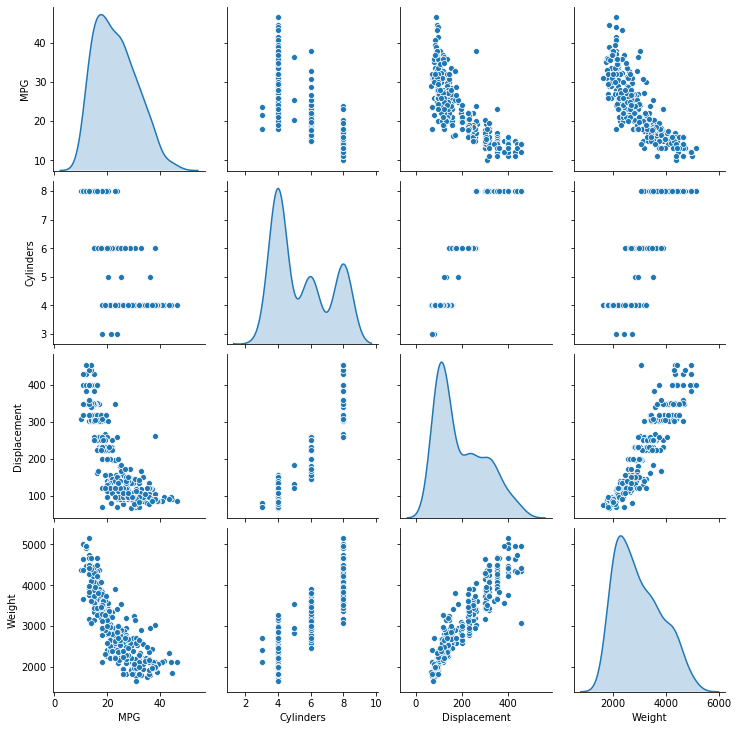

In [17]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [18]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [0]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

### Model

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [22]:
model = build_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [25]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.17291053],
       [-0.21334906],
       [ 0.16890089],
       [-0.20912534],
       [ 0.03928566],
       [ 0.01854754],
       [ 0.02465299],
       [-0.45492703],
       [ 0.00834268],
       [ 0.0207279 ]], dtype=float32)

In [26]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:578.8264,  mean_absolute_error:22.7147,  mean_squared_error:578.8264,  val_loss:581.8893,  val_mean_absolute_error:22.6953,  val_mean_squared_error:581.8893,  
....................................................................................................
Epoch: 100, loss:5.9436,  mean_absolute_error:1.7274,  mean_squared_error:5.9436,  val_loss:8.8298,  val_mean_absolute_error:2.2128,  val_mean_squared_error:8.8298,  
....................................................................................................
Epoch: 200, loss:5.2144,  mean_absolute_error:1.5673,  mean_squared_error:5.2144,  val_loss:8.4721,  val_mean_absolute_error:2.1994,  val_mean_squared_error:8.4721,  
....................................................................................................
Epoch: 300, loss:4.9489,  mean_absolute_error:1.5063,  mean_squared_error:4.9489,  val_loss:8.9349,  val_mean_absolute_error:2.2433,  val_mean_squared_error:8.9349,  
....................

In [27]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.721556,1.024135,2.721556,9.293766,2.358072,9.293767,995
996,2.664228,1.037019,2.664228,10.419048,2.544410,10.419048,996
997,3.123401,1.124767,3.123401,9.857586,2.482091,9.857587,997
998,2.851749,1.048842,2.851749,9.453916,2.415864,9.453916,998
999,2.711159,1.027220,2.711159,9.635831,2.454118,9.635831,999


In [0]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

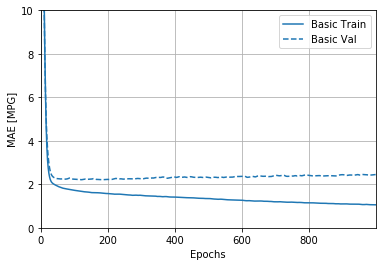

In [34]:
plotter.plot({'Basic': history}, metric="mean_absolute_error")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

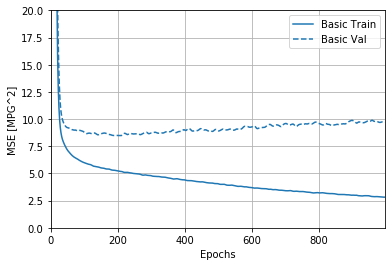

In [36]:
plotter.plot({'Basic': history}, metric = "mean_squared_error")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [37]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:571.0054,  mean_absolute_error:22.5957,  mean_squared_error:571.0054,  val_loss:555.5014,  val_mean_absolute_error:22.2619,  val_mean_squared_error:555.5013,  
.........................................................................................

Text(0, 0.5, 'MAE [MPG]')

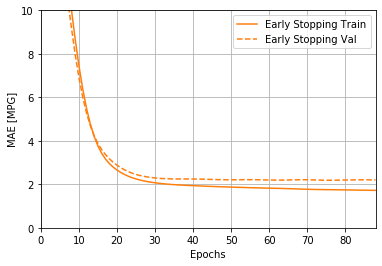

In [38]:
plotter.plot({'Early Stopping': early_history}, metric = "mean_absolute_error")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [39]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.9647 - mean_absolute_error: 1.9631 - mean_squared_error: 5.9647
Testing set Mean Abs Error:  1.96 MPG


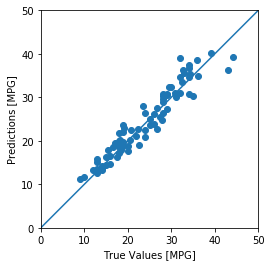

In [40]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

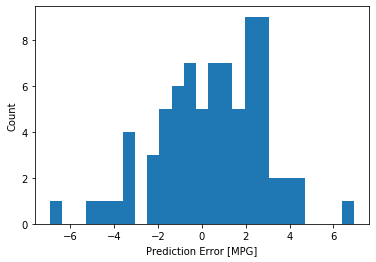

In [41]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")